In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from scipy import signal
from scipy.fftpack import fft

import pandas as pd
import os

from sklearn import datasets
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split



Using TensorFlow backend.


In [2]:
# pwd
# var = pd.read_csv(r"/Users/utkarshtripathi/Documents/PlatformIO/Projects/test.csv")
# var.head() #check starting lines of dataset

# Part-1: Analyzing simulated EMG signal
- Create a simulated signal 
- Use baseline offset correction and check results
- Fourier Transform example for sine wave
- FFT for simulated signal
- Use butterworth filter on signal
- Analyze fourier transform of filtered signal

In [3]:
# simulated EMG signal [emg1: with offset and emg2: without offset]
burst1 = np.random.uniform(-1, 1, size=500) + 0.08 # 800 samples between -1 and +1 Volts
burst2 = np.random.uniform(-1, 1, size=500) + 0.08
quiet = np.random.uniform(-0.05, 0.05, size=500) + 0.08

burst1x = np.random.uniform(-1, 1, size=500) # 800 samples between -1 and +1 Volts
burst2x = np.random.uniform(-1, 1, size=500)
quietx = np.random.uniform(-0.05, 0.05, size=500)

emg1 = np.concatenate([quiet, burst1, quiet, burst2, quiet])
emg2 = np.concatenate([quietx, burst1x, quietx, burst2x, quietx])

time = np.array([i/1000 for i in range(0, len(emg1), 1)]) # sampling rate 1000 Hz
# generate a **list** of integer values ranging from 0 to the length of the variable emg


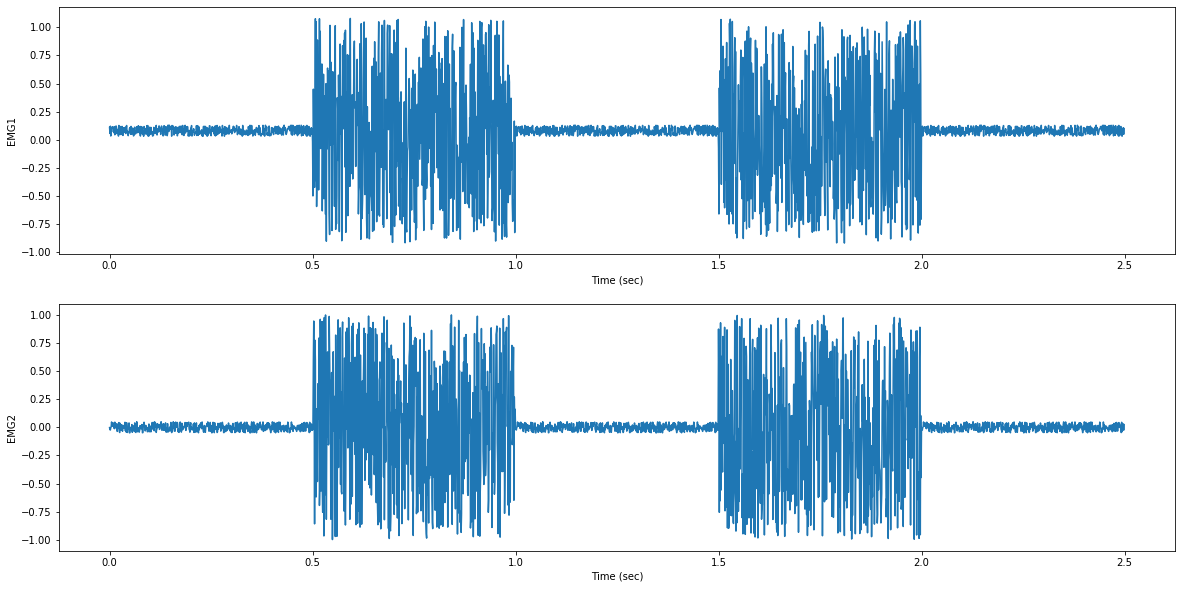

In [4]:
# plot EMG1 signal
fig = plt.figure()

plt.subplot(2,1,1)
plt.plot(time, emg1)
plt.xlabel('Time (sec)')
plt.ylabel('EMG1')

plt.subplot(2,1,2)
plt.plot(time, emg2)
plt.xlabel('Time (sec)')
plt.ylabel('EMG2')

fig.set_size_inches(w=20,h=10)
# fig.savefig('emg2.png')


In [5]:
# Baseline offset is not zero, solving:
# %whos # for checking variables
print ('Mean for first simulated emg signal' , np.mean(emg1))
print ('Mean for second simulated emg signal' , np.mean(emg2))

Mean for first simulated emg signal 0.06737236160272511
Mean for second simulated emg signal -0.0020534602423628798


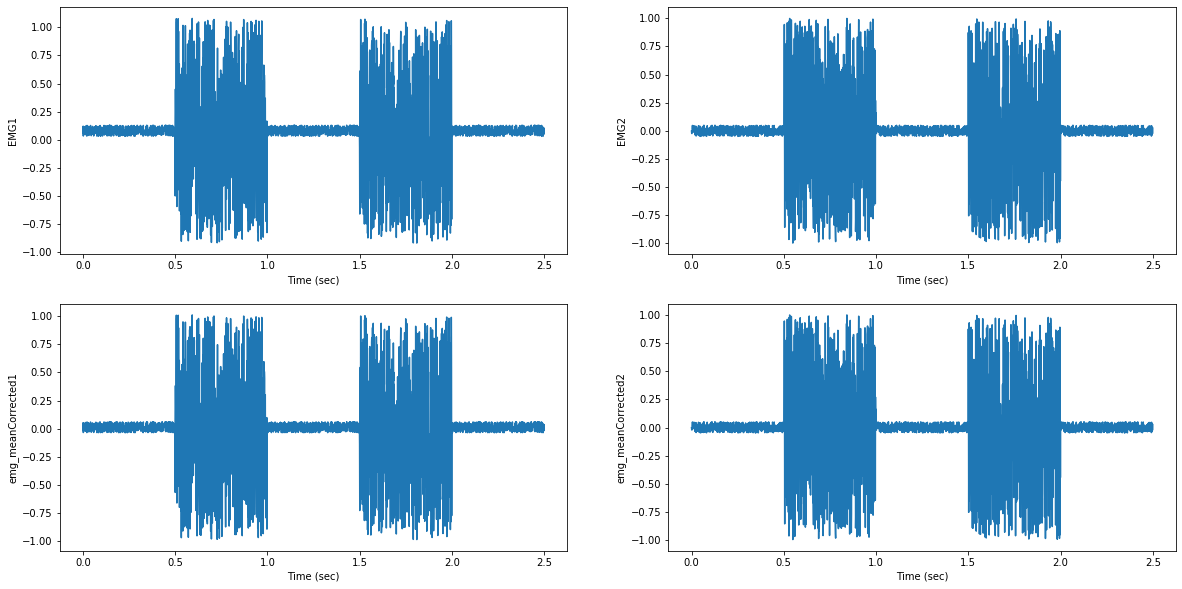

In [6]:
## Mean corrections [emg1: with offset and emg2: without offset]
emg_meanCorrected1 = emg1 - np.mean(emg1)
emg_meanCorrected2 = emg2 - np.mean(emg2)

# plot EMG1 signal
fig = plt.figure()

plt.subplot(2,2,1)
plt.plot(time, emg1)
plt.xlabel('Time (sec)')
plt.ylabel('EMG1')

plt.subplot(2,2,2)
plt.plot(time, emg2)
plt.xlabel('Time (sec)')
plt.ylabel('EMG2')

plt.subplot(2,2,3)
plt.plot(time, emg_meanCorrected1)
plt.xlabel('Time (sec)')
plt.ylabel('emg_meanCorrected1')

plt.subplot(2,2,4)
plt.plot(time, emg_meanCorrected2)
plt.xlabel('Time (sec)')
plt.ylabel('emg_meanCorrected2')

fig.set_size_inches(w=20,h=10)

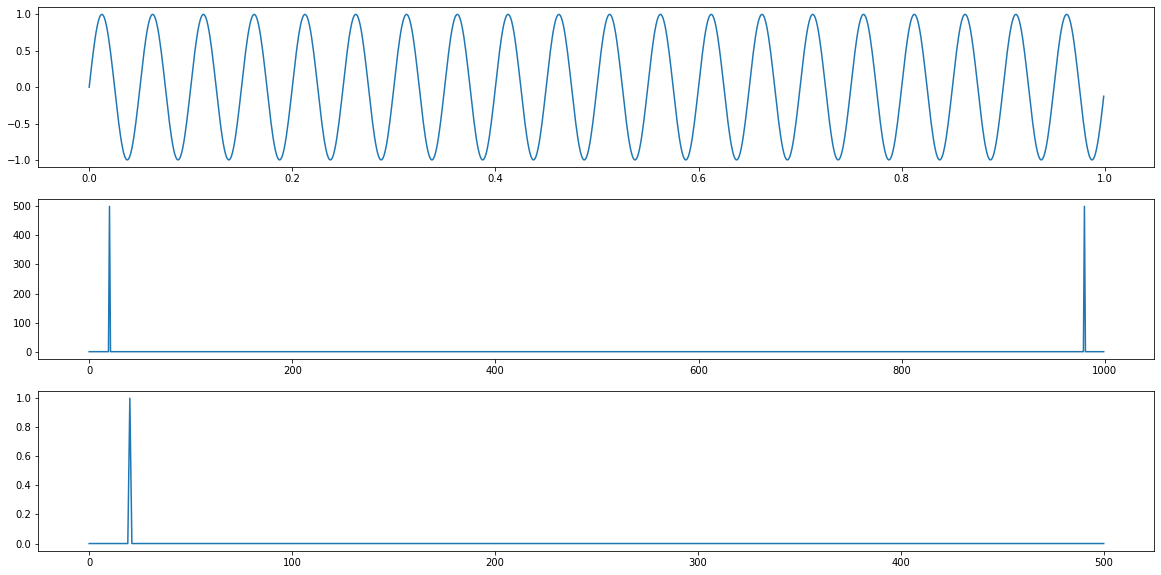

In [7]:
### Python fft testing with only sine wave to create the right fft

Fs = 1000 # Sampling frequency
sineFreq = 20
# t = np.linspace(0, 2, 100)
tx = np.arange(start=0, stop=1, step=1/Fs) # step == dt

# print(t)
# print(tx)

x = np.sin(2*np.pi*sineFreq * tx)
X = fft(x)

# Plot sine wave
fig = plt.figure()

plt.subplot(3,1,1)
plt.plot (tx,x)

plt.subplot(3,1,2)
plt.plot (abs(X)) # incorrect plot

## Frequency axis creation
n = np.size(tx)
freq_axis = (Fs/2) * np.linspace (0,1,n/2) # frequency axis: 0->500 Hz and generate half spectrum
X_corrected = abs( X[0:np.size(freq_axis)] ) * (2/n)

plt.subplot(3,1,3)
plt.plot (freq_axis,X_corrected) # Correct plot
fig.set_size_inches(w=20,h=10)


[0.000e+00 1.000e-03 2.000e-03 ... 2.497e+00 2.498e+00 2.499e+00] 2500


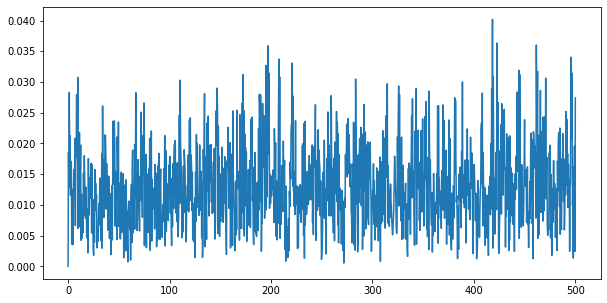

In [8]:
## Fourier transform on EMG signals. NOTE:
# emg1: with offset and emg2: without offset
# emg_meanCorrected1 emg_meanCorrected2
# FFT_emg_normalized => FT of emg_meanCorrected1

Fs_emg = 1000 # Sampling frequency (see first block)
print(time, np.size(time))

FFT_emg = fft(emg_meanCorrected1)

## Frequency axis creation
n_emg = np.size(time)
freq_axis_emg = (Fs/2) * np.linspace (0,1,n_emg/2) # frequency axis: 0->500 Hz and generate half spectrum
FFT_emg_normalized = abs( FFT_emg[0:np.size(freq_axis_emg)] ) * (2/n_emg)

fig = plt.figure()
plt.plot (freq_axis_emg,FFT_emg_normalized)
fig.set_size_inches(w=10,h=5)

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


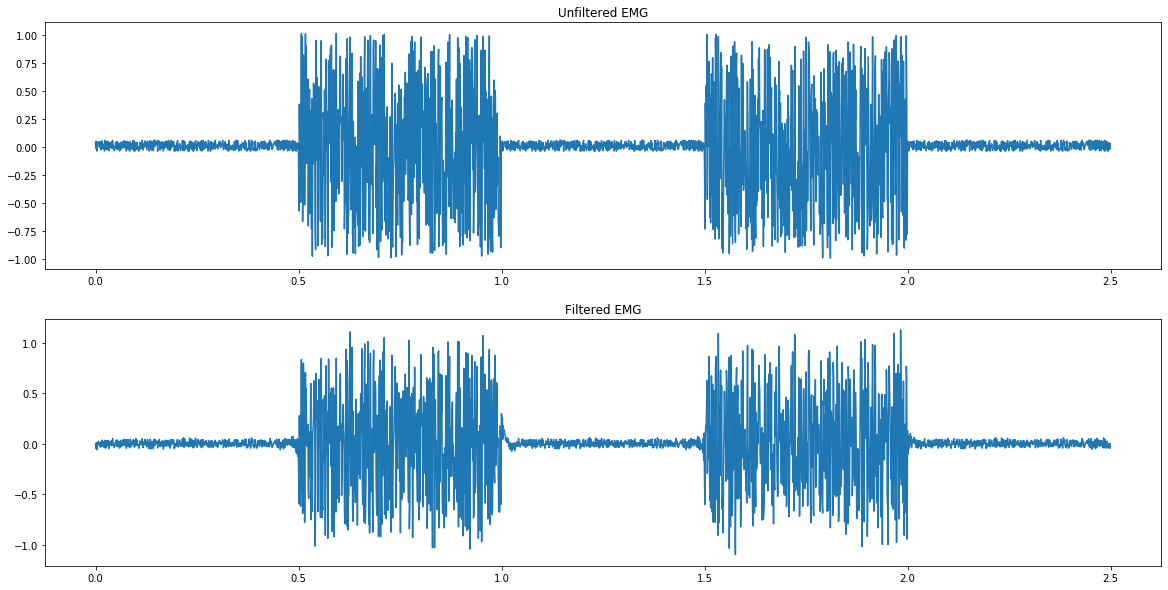

In [9]:
## BANDPASS FILTERING
## Comparison of ---FFT_emg_normalized--- and ---FFT_emg_filtered_normalized---

# Slow oscillations in the EMG signal -> movement artefacts 
# Fast oscillations -> unwanted electrical noise
# Add bandpass filter to avoid both (20-450 Hz) :

high = 20/(Fs/2)
low = 450/(Fs/2)
b, a = sp.signal.butter(4, [high,low], btype='bandpass')

# Process EMG signal: filter EMG
emg_filtered = sp.signal.filtfilt(b, a, emg_meanCorrected1)

# "TIME DOMAIN" plot comparison of unfiltered and filtered EMG
fig = plt.figure()
fig.set_size_inches(w=11,h=7)

plt.subplot(2, 1, 1)
plt.subplot(2, 1, 1).set_title('Unfiltered EMG')
plt.plot(time, emg_meanCorrected1)

plt.subplot(2, 1, 2)
plt.subplot(2, 1, 2).set_title('Filtered EMG')
plt.plot(time, emg_filtered)
fig.set_size_inches(w=20,h=10)



/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


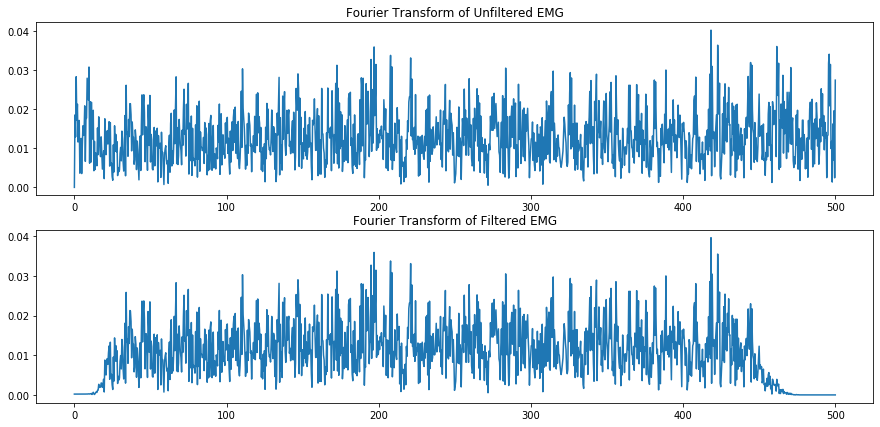

In [10]:
# FFT_emg_normalized => FT of emg_meanCorrected1
# FFT_emg_filtred_normalized => FT of emg_filtered

FFT_emg_filtered = fft(emg_filtered)
FFT_emg_filtered_normalized = abs( FFT_emg_filtered[0:np.size(freq_axis_emg)] ) * (2/n_emg)

# "FREQUENCY DOMAIN" plot comparison of unfiltered and filtered EMG
fig = plt.figure()

plt.subplot(2, 1, 1)
plt.subplot(2, 1, 1).set_title('Fourier Transform of Unfiltered EMG')
plt.plot(freq_axis_emg, FFT_emg_normalized)

plt.subplot(2, 1, 2)
plt.subplot(2, 1, 2).set_title('Fourier Transform of Filtered EMG')
plt.plot(freq_axis_emg, FFT_emg_filtered_normalized)

fig.set_size_inches(w=15,h=7)


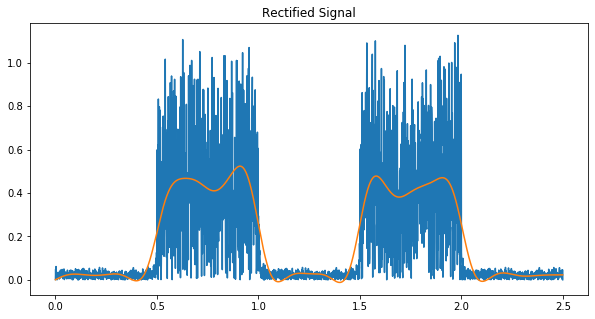

In [11]:
## Rectification of signal - take abs
RECT_emg_filtered = abs (emg_filtered)
fig = plt.figure()
fig.set_size_inches(w=10,h=5)
plt.title('Rectified Signal')
plt.plot(time, RECT_emg_filtered)

low_pass = 10
low_pass = low_pass/Fs
b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
emg_envelope = sp.signal.filtfilt(b2, a2, RECT_emg_filtered)
plt.plot(time, emg_envelope)



<class 'numpy.ndarray'>
(2500,)


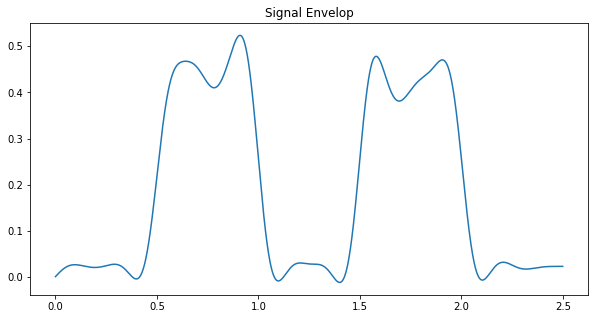

In [12]:
## EMG Envelop generation

# Use a low pass filter to capture the shape or “envelope” of the EMG signal -> 
# better reflects force generated by a muscle

low_pass = 10
low_pass = low_pass/Fs
b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
emg_envelope = sp.signal.filtfilt(b2, a2, RECT_emg_filtered)
fig = plt.figure()
fig.set_size_inches(w=10,h=5)
plt.title('Signal Envelop')
plt.plot(time, emg_envelope)

print(type(emg_envelope))
print(np.shape(emg_envelope))

# Part-2: Stochastic Signal Analysis and Machine Learning Classification

- Fourier analysis can be used to decompose this signal in its periodic components. Fourier analysis tells us at what the frequency of these periodical component are.
- Defining function to quickly calculate fft as and when required

### Power Spectral Density and Auto-correlation
PSD:
- Frequency distribution + Power distribution at each frequency
- The surface below the peaks corresponds with the power distribution at that frequency.

Autocorrelation:
- correlation of a signal with a time-delayed version of itself
- if a signal contain a pattern which repeats itself after a time-period of \tau seconds, there will be a high correlation between the signal and a \tau sec delayed version of the signal.



In [13]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

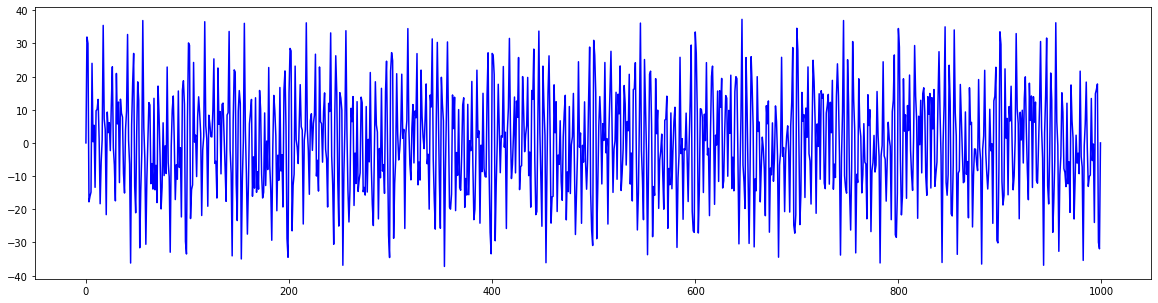

In [14]:
from scipy.signal import welch # for PSD

t_n = 10
N = 1000
T = t_n / N
f_s = 1/T

x_value = np.linspace(0,t_n,N)
amplitudes = [4, 6, 8, 10, 14, 10]
frequencies = [1, 24, 13, 18, 20, 54]
y_values = [amplitudes[ii] * np.sin(2*np.pi*frequencies[ii]*x_value) for ii in range(0,len(amplitudes))]
composite_y_value = np.sum(y_values, axis=0)

# print(y_values)gt

# Use the function defined above (makes use of Sci)
f_values_fft, fft_values = get_fft_values(composite_y_value, T, N, f_s) ## FFT
f_values_psd, psd_values = welch (composite_y_value, f_s) ## PSD

fig = plt.figure()
plt.plot(composite_y_value, color='blue')
fig.set_size_inches(w=20,h=5)

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


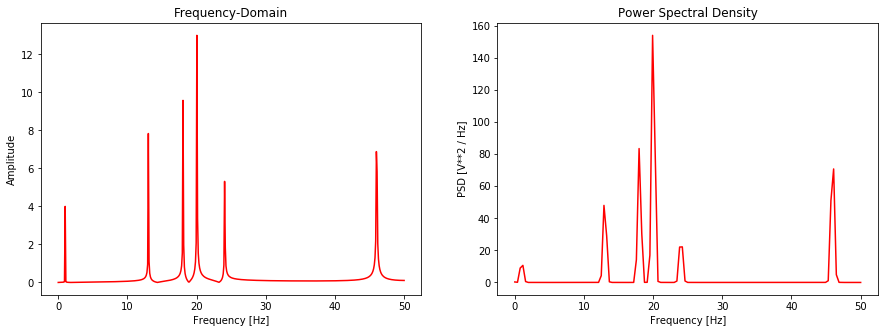

In [15]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Frequency-Domain')
plt.plot(f_values_fft, fft_values, linestyle='-', color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude') ##

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Power Spectral Density')
plt.plot(f_values_psd, psd_values, color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')

fig.set_size_inches(w=15,h=5)

In [16]:
# from autocorrelation import autocorr
# from autocorrelation import get_autocorr_values

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


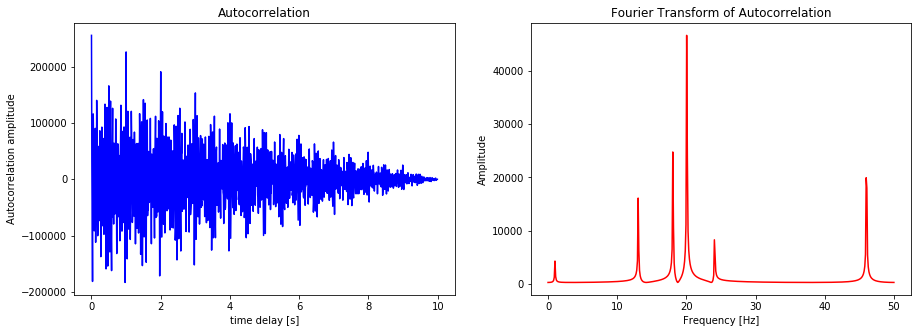

In [17]:
# Autocorrelation calculation
t_values, autocorr_values = get_autocorr_values(composite_y_value, T, N, f_s)

# Checking the FFT of autocorrelation calculated above (should be very similar to FFT of original signal)
f_values_ac, fft_values_ac = get_fft_values(autocorr_values, T, N, f_s) 

# Plot both autocorrelation and frequency domain
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Autocorrelation')
plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Fourier Transform of Autocorrelation')
plt.plot(f_values_ac, fft_values_ac, linestyle='-', color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude') ##

fig.set_size_inches(w=15,h=5)

Now extract features from each of these transformed signals (FFT, PSD and AutoCorrelation) and use these **features as input** in standard classifiers like Random Forest, Logistic Regression, Gradient Boosting or Support Vector Machines. One of these features is (peaks' frequency and amplitude) -> So need to find the peak first and find the corresponding frequency. 

#### FINDING PEAKS IN FREQUENCY DOMAIN

NOTE THE FOLLOWING: (https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/58888/versions/1/previews/Averaged_loop_example/fndpks.m/index.html)

* find only those peaks that are greater than MINPEAKHEIGHT MPH. Specifying a minimum peak height may help in reducing the processing time. MPH is a real valued scalar. The default value of MPH is -Inf.

* finds peaks that are at least separated by MINPEAKDISTANCE MPD. MPD is a positive integer valued scalar. This parameter may be specified to ignore smaller peaks that may occur in close proximity to a large local peak. For example, if a large local peak occurs at index N, then all smaller peaks in the range (N-MPD, N+MPD) are ignored. If not specified, MPD is assigned a value of one. 



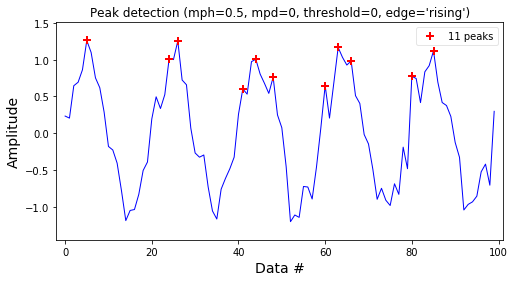

In [18]:
# %load detect_peaks.py
# function detect_peaks is present in the same folder as the notebook

from detect_peaks import detect_peaks 

x = np.sin(2*np.pi*5*np.linspace(0, 1, 100)) + (np.random.randn(100))/5
# set minimum peak height = 0.5 and minimum peak distance = 0
ind = detect_peaks(x, mph=0.5, mpd=0, show=True)

# x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
# # detection of valleys instead of peaks
# detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)


In [19]:
## Finding Peaks in the FFT (calculated above) as one of the features

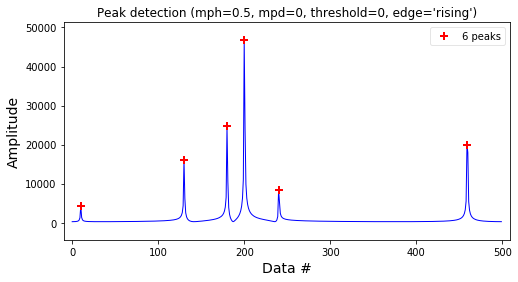

In [20]:

i2 = detect_peaks(fft_values_ac, mph=0.5, mpd=0, show=True)



---
---
---
---
---
---
---
---
---
---
---
---








# Analyzing Data Collected through EMG

---
---
---
---
---
---


In [21]:
# on off :  for data collected across Flexor Digitorum Superficialis
# on off 2: for data collected across Flexor Digitorum Superficialis (hard pressed)
# sec 10: for data collected across Flexor Digitorum Superficialis + 10secs open, 10secs closed

var_onoff = pd.read_csv(r"/Users/utkarshtripathi/Documents/PlatformIO/Projects/Data_Collected/onoff.csv")
var_onoff_2 = pd.read_csv(r"/Users/utkarshtripathi/Documents/PlatformIO/Projects/Data_Collected/onoff2.csv")
var_sec10 = pd.read_csv(r"/Users/utkarshtripathi/Documents/PlatformIO/Projects/Data_Collected/sec10.csv")
print (np.size(var_onoff), type(var_onoff))
print (np.size(var_onoff_2), type(var_onoff_2))
print (np.size(var_sec10), type(var_sec10))

# var.head() # check starting lines of dataset

9004 <class 'pandas.core.frame.DataFrame'>
6604 <class 'pandas.core.frame.DataFrame'>
13281 <class 'pandas.core.frame.DataFrame'>


## Plotting data collected through MyoWare

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an ax

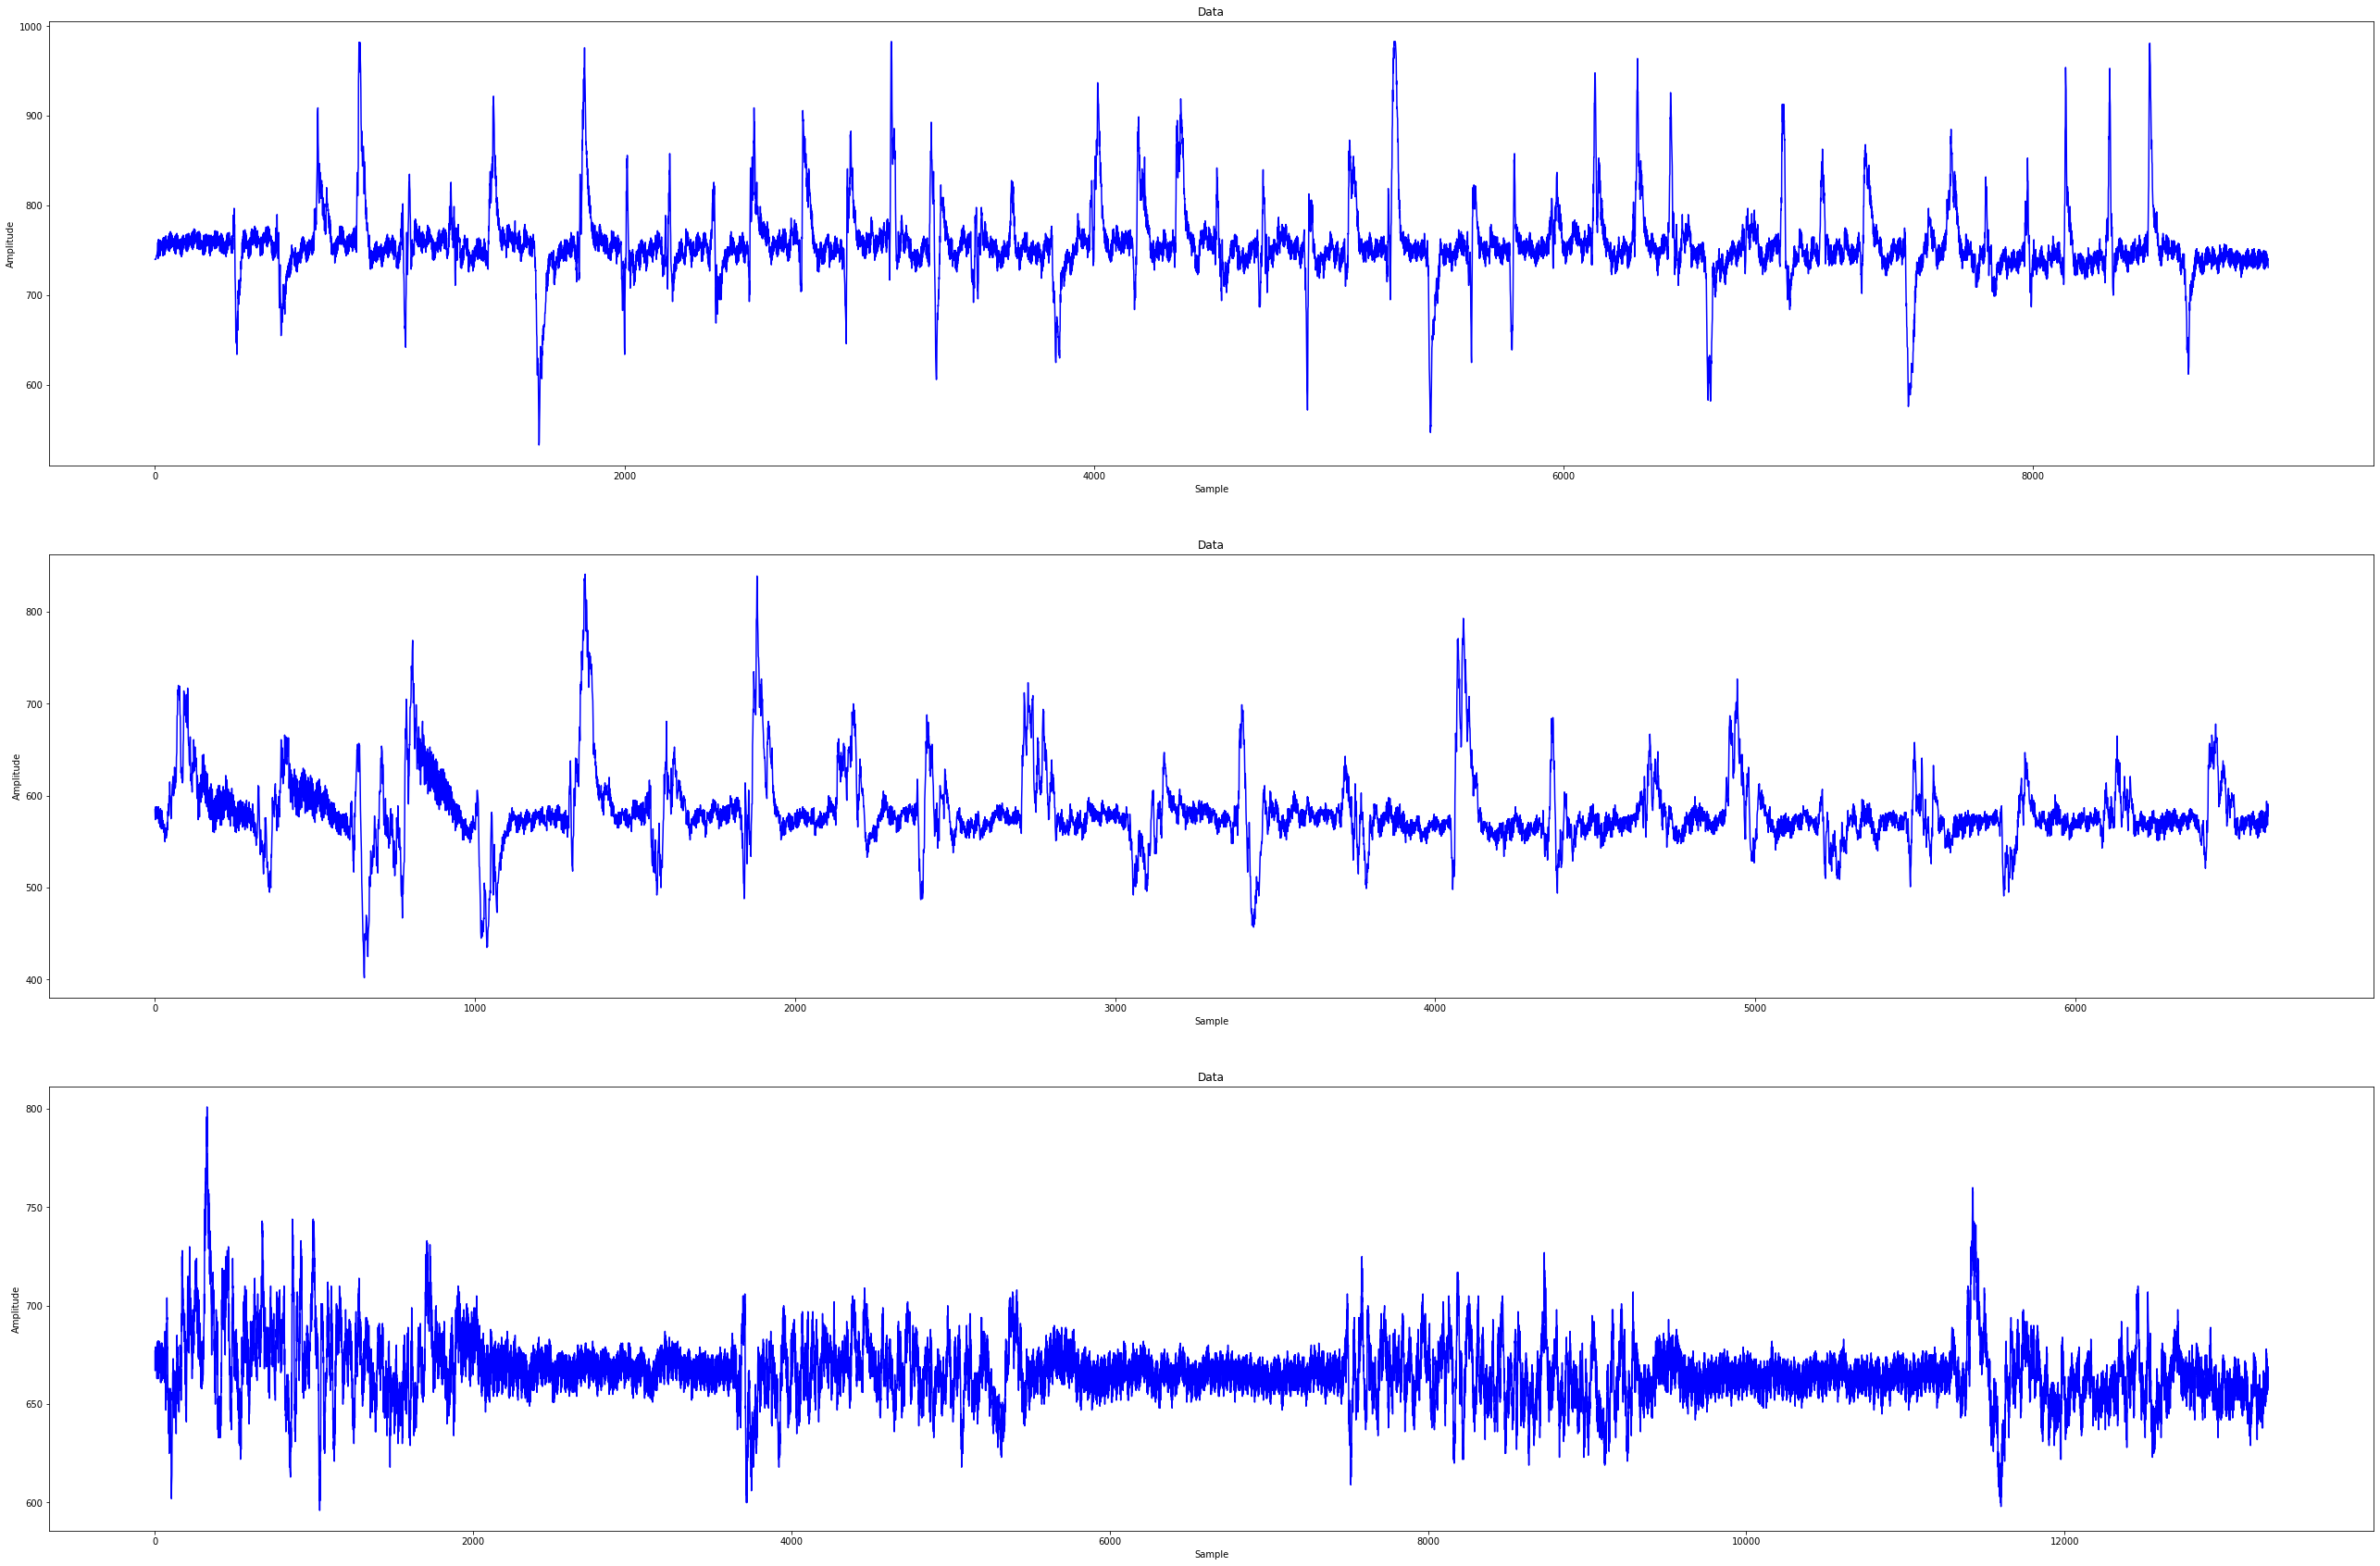

In [22]:
# Plot 
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.subplot(3, 1, 1).set_title('Data')

plt.plot(var_onoff, linestyle='-', color='blue')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.subplot(3, 1, 2).set_title('Data')

plt.plot(var_onoff_2, linestyle='-', color='blue')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.subplot(3, 1, 3).set_title('Data')

plt.plot(var_sec10, linestyle='-', color='blue')
plt.xlabel('Sample')
plt.ylabel('Amplitude')


fig.set_size_inches(w=45,h=30)

## Visualizing open & closed hand

Text(0.5, 1.0, 'open: blue and closed: orange')

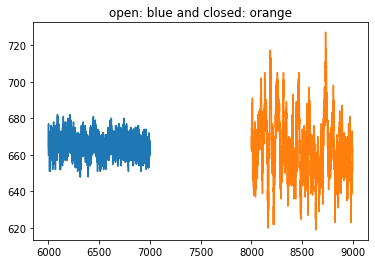

In [24]:
# Take FFT of two parts of 3rd signal (open palm and closed fist):
# 13280 samples in ~70 seconds (~190 Hz)

t_n = 5.27 # Time for these 1000 samples 
N = 1000   # number of samples
T = t_n / N
f_s = 1/T

var_open   =  var_sec10[6000:7000]
var_closed =  var_sec10[8000:9000]
plt.plot(var_open)
plt.plot(var_closed)
plt.title('open: blue and closed: orange')
# fval_var_open, fft_var_f_open   = get_fft_values(var_open, T, N, f_s) # FFT
# fval_var_close, fft_var_f_close = get_fft_values(var_closed, T, N, f_s) # FFT

# yf = fftpack.fft(var_open, time.size)
# amp = np.abs(yf) # get amplitude spectrum 
# freq = fftpack.fftfreq(time.size, 6/500)
# plt.figure(figsize=(10,6))
# plt.plot(freq[0:freq.size//2], (2/amp.size)*amp[0:amp.size//2])
# plt.show()




## Calculating Fourier transform to check presence and amplitudes of different frequencies, need correction

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


NameError: name 'fval_var_close' is not defined

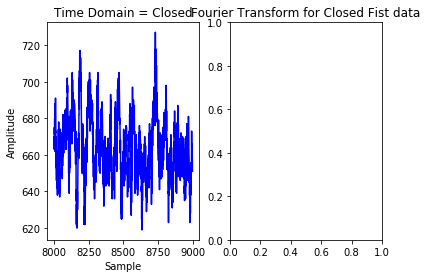

In [25]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Time Domain = Closed')
plt.plot(var_closed, linestyle='-', color='blue')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Fourier Transform for Closed Fist data')
plt.plot(fval_var_close, fft_var_f_close, linestyle='-', color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude') ##

fig.set_size_inches(w=20,h=5)

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


NameError: name 'fval_var_open' is not defined

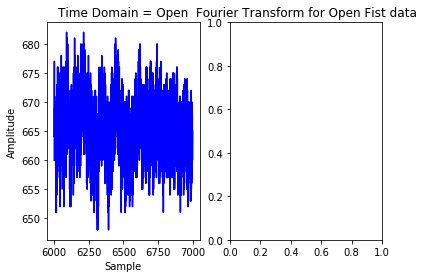

In [26]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Time Domain = Open')
plt.plot(var_open, linestyle='-', color='blue')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Fourier Transform for Open Fist data')
plt.plot(fval_var_open, fft_var_f_open, linestyle='-', color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude') ##

fig.set_size_inches(w=20,h=5)

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


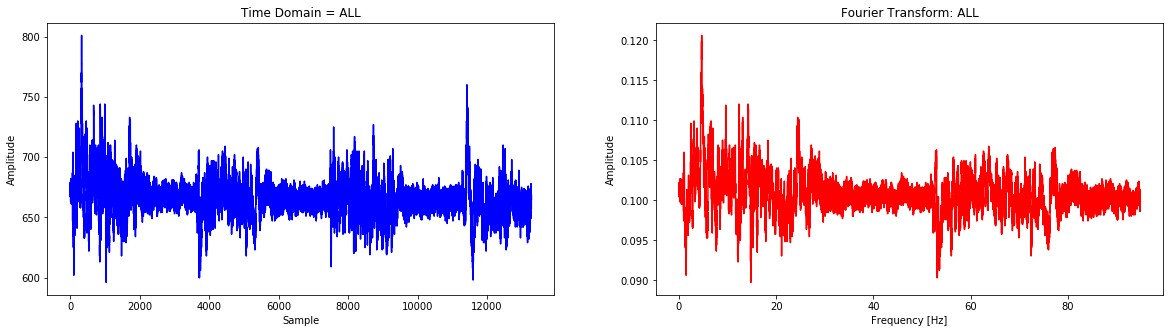

In [27]:
## FT of full signal
t_n = 70 # Time for these all samples 
N = 13281   # number of samples
T = t_n / N
f_s = 1/T

fval_var_all, fft_var_f_all   = get_fft_values(var_sec10, T, N, f_s) # FFT

fig = plt.figure()

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Time Domain = ALL')
plt.plot(var_sec10, linestyle='-', color='blue')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Fourier Transform: ALL')
plt.plot(fval_var_all, fft_var_f_all, linestyle='-', color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude') ##

fig.set_size_inches(w=20,h=5)

## Calculating means and standard deviations via windowing,
## These will be used as initial features

### Note: mean_all_tmp:   for raw signal
### Note: mean_all_tmp2: for rectified/absolute signal
### Note: mean_all_tmp3: for envelop

In [28]:
window_size = 100
n_windows = (np.size(var_sec10)//window_size)
i=0
j=0
mean_all, mean_all_tmp, mean_all_t = [],[],[]
stdev_all, stdev_tmp, stdev_t = [],[],[]


for i in range(0, n_windows):
    x = var_sec10[ (i*window_size): (i*window_size)+window_size] # mean values
    # standard deviations
    mean_all_tmp.append(np.average(x)) # fill in the averages for windows
    stdev_tmp.append(np.std(x)) # fill in the averages for windows

# Since size of mean_all ≠ size of mean_all_t. Time axis:
for i in range(0, n_windows):
    mean_all_t.append(i*window_size)


Text(0.5, 1.0, 'Cyan: original signal, Blue: Means of 100 sample windows')

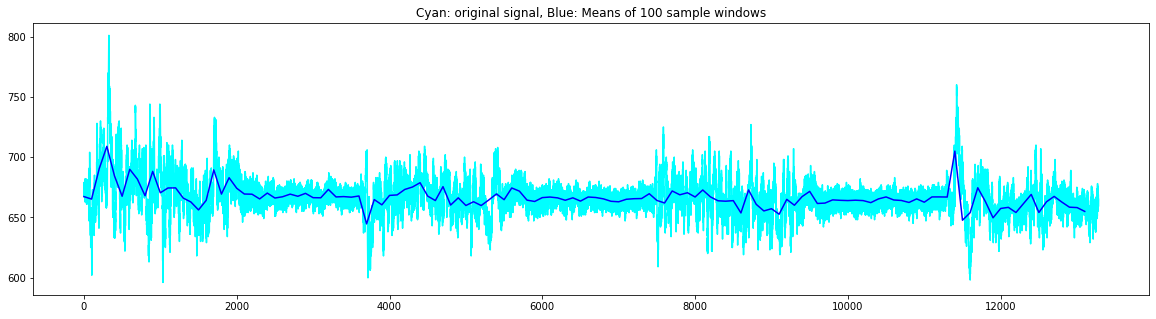

In [29]:
# print(np.size(mean_all_tmp))
# print(np.size(mean_all_t))
# print(np.mean(var_sec10))

# print(np.size(stdev_tmp))
# print(mean_all_tmp)
# print(mean_all_t)

fig_mean = plt.figure()
fig_mean.set_size_inches(w=20,h=5)      
plt.plot(var_sec10, linestyle='-', color='cyan')
plt.plot(mean_all_t, mean_all_tmp,color='blue')
plt.title('Cyan: original signal, Blue: Means of 100 sample windows')

Text(0.5, 1.0, 'Standard deviations for raw signal')

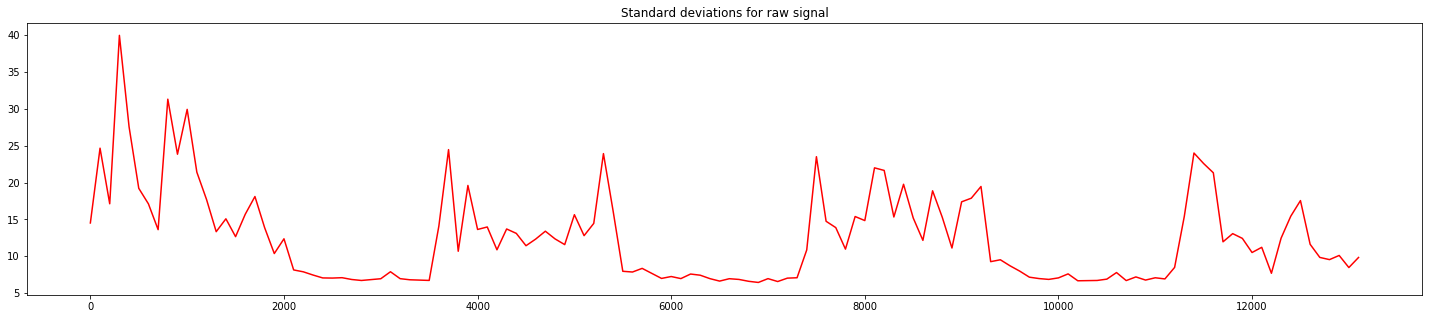

In [30]:

fig_stdev = plt.figure()
plt.plot(mean_all_t, stdev_tmp,color='red')
fig_stdev.set_size_inches(w=25,h=5)
plt.title('Standard deviations for raw signal')

## Rectification and normalization of signal 
## Followed by calculation of features (from the normalized signal)

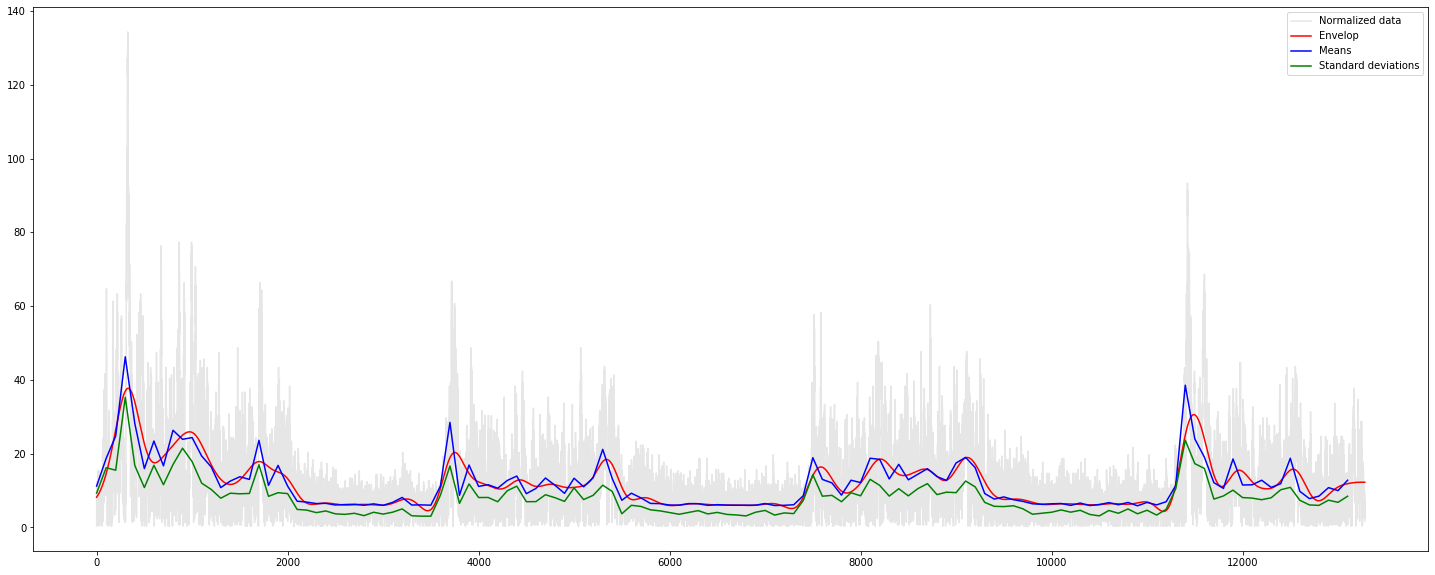

In [31]:
## Rectification

data_temp1 = var_sec10 - np.mean(var_sec10)
data_norm = abs(data_temp1)


data_norm_np = data_norm.to_numpy()
data_norm_np = data_norm_np.reshape((np.size(data_norm_np),))
low_pass = 1
low_pass = low_pass/f_s
b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')

#############################################################################################
emg_envelope_sig = sp.signal.filtfilt(b2, a2, x = data_norm_np)
#############################################################################################

## NOW CALCULATE MEANS and VARIANCES 
window_size2 = 100
n_windows2 = (np.size(data_norm_np)//window_size2)
mean_all2, mean_all_tmp2, mean_all_t2 = [],[],[]
stdev_all2, stdev_tmp2, stdev_t2 = [],[],[]

for i in range(0, n_windows2):
    x2 = data_norm_np[ (i*window_size2): (i*window_size2)+window_size2] # mean values
    # standard deviations
    mean_all_tmp2.append(np.average(x2)) # fill in the averages for windows
    stdev_tmp2.append(np.std(x2)) # fill in the averages for windows

# Since size of mean_all ≠ size of mean_all_t. Time axis:
for i in range(0, n_windows2):
    mean_all_t2.append(i*window_size2)


# PLOT    
fig_stdev = plt.figure()
fig_stdev.set_size_inches(w=25,h=10)
plt.plot(data_norm_np, color='0.9',label='Normalized data')
plt.plot(emg_envelope_sig, color='r',label='Envelop')
plt.plot(mean_all_t2, mean_all_tmp2, color='b',label='Means')
plt.plot(mean_all_t2, stdev_tmp2, color='g',label='Standard deviations')
plt.legend();


## data_norm_np is grey


### CALCULATING MEANS AND STD DEV OF ENVELOP (3)

13281


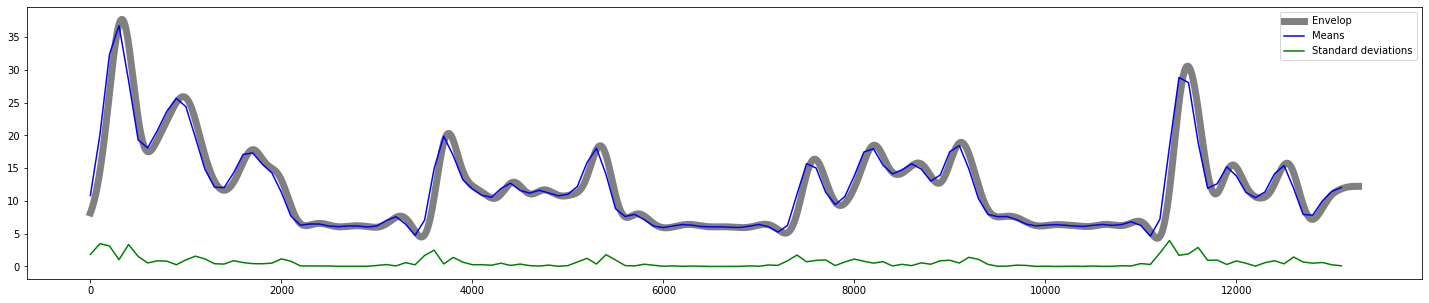

In [32]:
print(np.size(emg_envelope_sig))

## NOW CALCULATE MEANS and VARIANCES 
window_size3 = 100
n_windows3 = (np.size(emg_envelope_sig)//window_size3)
mean_all3, mean_all_tmp3, mean_all_t3 = [],[],[]
stdev_all3, stdev_tmp3, stdev_t3 = [],[],[]

for i in range(0, n_windows3):
    x3 = emg_envelope_sig[ (i*window_size3): (i*window_size3)+window_size3] # mean values
    # standard deviations
    mean_all_tmp3.append(np.average(x3)) # fill in the averages for windows
    stdev_tmp3.append(np.std(x3)) # fill in the averages for windows

# Since size of mean_all ≠ size of mean_all_t. Time axis:
for i in range(0, n_windows3):
    mean_all_t3.append(i*window_size3)
    
# PLOT    
fig_stdev = plt.figure()
fig_stdev.set_size_inches(w=25,h=5)   
plt.plot(emg_envelope_sig, color='0.5',label='Envelop',linewidth=7.0)
plt.plot(mean_all_t3, mean_all_tmp3, color='b',label='Means')
plt.plot(mean_all_t3, stdev_tmp3, color='g',label='Standard deviations')
plt.legend()


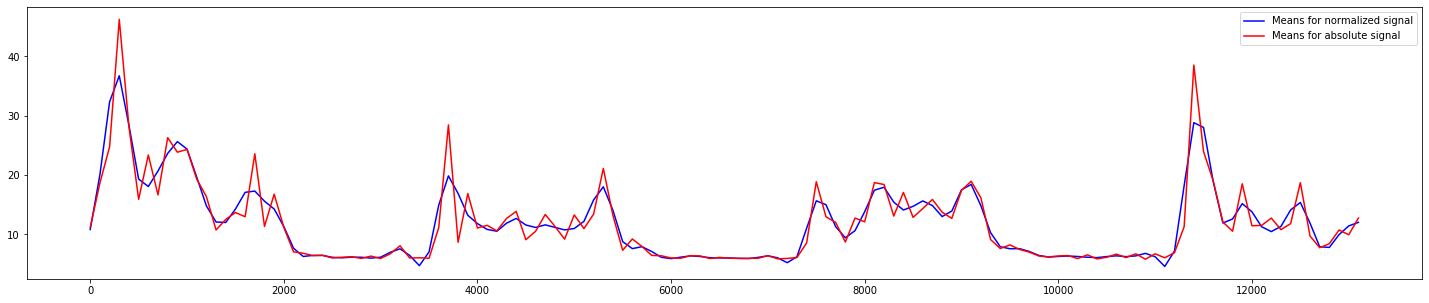

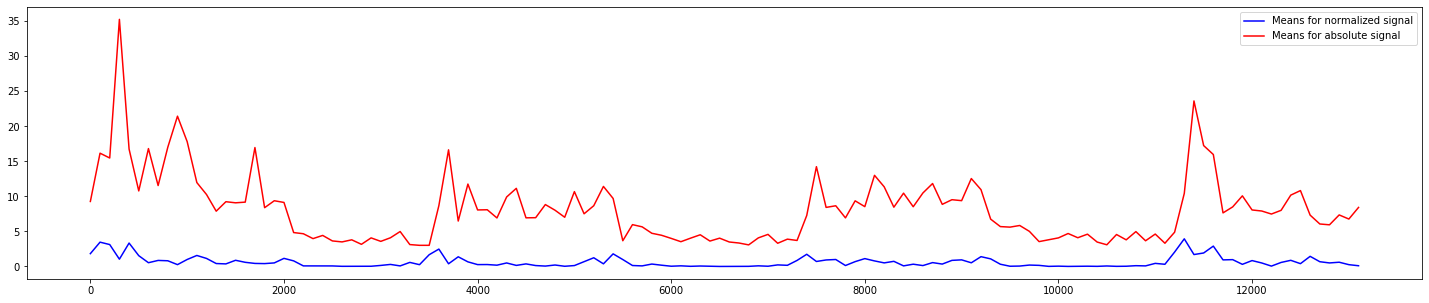

In [33]:
# PLOT prev and new means and dev

fig_stdev = plt.figure()
fig_stdev.set_size_inches(w=25,h=5)   
plt.plot(mean_all_t3, mean_all_tmp3, color='b',label='Means for normalized signal')
plt.plot(mean_all_t2, mean_all_tmp2, color='r',label='Means for absolute signal')
plt.legend()

fig_stdev2 = plt.figure()
fig_stdev2.set_size_inches(w=25,h=5)   
plt.plot(mean_all_t3, stdev_tmp3, color='b',label='Means for normalized signal')
plt.plot(mean_all_t2, stdev_tmp2, color='r',label='Means for absolute signal')
plt.legend()


In [34]:
## [-,-,-,-,- ....... ,-,-,-] Current mean_all_tmp and stdev_tmp sizes: 132
## [1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1....] 132/7 ≈ 19 ---> 19 ones followed by 19 zeros and so on

x = 7 #  total number of contractions & relaxations in the series
mask_1 = np.full( (n_windows//x)+1, 1 )
mask_0 = np.full( (n_windows//x)+1, 0 )
class_binary = []

print (((np.size(mean_all_tmp))//(np.size(mask_1)))//2)
for i in range ( 0, ( ((np.size(mean_all_tmp))//(np.size(mask_1)))//2) ):
    class_binary.append(mask_0)
    class_binary.append(mask_1)

class_binary.append(mask_0)
class_binary = np.reshape(class_binary,np.size(class_binary), order='A')
class_binary = np.resize(class_binary, class_binary.size-1) # np.delete(class_binary, (-1))
print(np.shape(class_binary))

# plt.plot(mean_all_tmp, stdev_tmp, '>', color='black')


3
(132,)


(2, 132)
(2, 132)
(2, 132)
Pink: open, Blue: Closed


/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

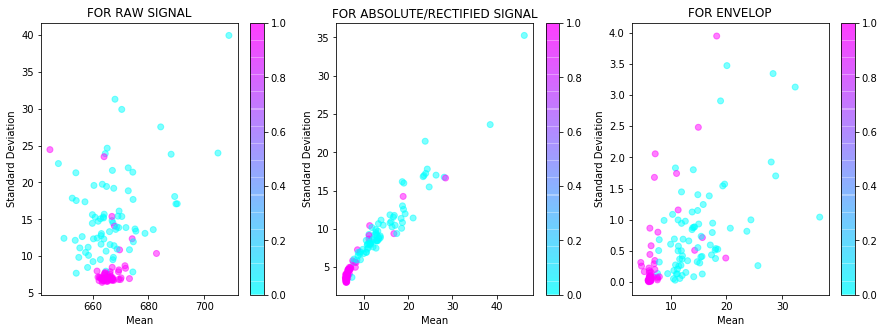

In [35]:
import matplotlib.cm as cm

mean_all_tmp_reshaped = (np.reshape(mean_all_tmp, (1,np.size(mean_all_tmp))))
stdev_tmp_reshaped    = (np.reshape(stdev_tmp, (1,np.size(mean_all_tmp))))
features_mean_stddev = np.vstack((mean_all_tmp_reshaped, stdev_tmp_reshaped))
print(np.shape(features_mean_stddev))

mean_all_tmp_reshaped2 = (np.reshape(mean_all_tmp2, (1,np.size(mean_all_tmp2))))
stdev_tmp_reshaped2    = (np.reshape(stdev_tmp2, (1,np.size(mean_all_tmp2))))
features_mean_stddev2 = np.vstack((mean_all_tmp_reshaped2, stdev_tmp_reshaped2))
print(np.shape(features_mean_stddev2))

mean_all_tmp_reshaped3 = (np.reshape(mean_all_tmp3, (1,np.size(mean_all_tmp3))))
stdev_tmp_reshaped3    = (np.reshape(stdev_tmp3, (1,np.size(mean_all_tmp3))))
features_mean_stddev3 = np.vstack((mean_all_tmp_reshaped3, stdev_tmp_reshaped3))
print(np.shape(features_mean_stddev3))


# from sklearn.datasets import load_iris
# iris = load_iris()
# features = iris.data.T
# print(features.shape)
# feature[0] : -,-,-,-,-,-,-, .... -,-,-,-,-,-,-
# feature[1] : -,-,-,-,-,-,-, .... -,-,-,-,-,-,-
# feature[2] : -,-,-,-,-,-,-, .... -,-,-,-,-,-,-
# feature[3] : -,-,-,-,-,-,-, .... -,-,-,-,-,-,-

fig = plt.figure()
fig.set_size_inches(w=15,h=5)

plt.subplot(1, 3, 1)
plt.subplot(1, 3, 1).set_title('FOR RAW SIGNAL')
plt.scatter(features_mean_stddev[0], features_mean_stddev[1], c = class_binary, alpha=0.5, cmap = cm.cool) #s=10
plt.colorbar() # 0 is for clenched state, 1 is for openn state
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')

plt.subplot(1, 3, 2)
plt.subplot(1, 3, 2).set_title('FOR ABSOLUTE/RECTIFIED SIGNAL')
plt.scatter(features_mean_stddev2[0], features_mean_stddev2[1], c = class_binary, alpha=0.5, cmap = cm.cool) #s=10
plt.colorbar() # 0 is for clenched state, 1 is for openn state
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')

plt.subplot(1, 3, 3)
plt.subplot(1, 3, 3).set_title('FOR ENVELOP')
plt.scatter(features_mean_stddev3[0], features_mean_stddev3[1], c = class_binary, alpha=0.5, cmap = cm.cool) #s=10
plt.colorbar() # 0 is for clenched state, 1 is for openn state
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')

print('Pink: open, Blue: Closed')

# print(np.shape(x))

In [36]:
### For making decision boundaries after training (from rohitmidha23.github.io/Neural-Network-Decision-Boundary)
np.random.seed(0)

## make sure that X and y are np not dataFrames!
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)

    return fig, ax


In [37]:
# export the means and std deviations for first plot to csv
np.savetxt("/Users/utkarshtripathi/Documents/PlatformIO/Projects/Data_Collected/foo.csv", mean_all_tmp3, delimiter=",")


In [38]:

df = pd.read_csv(r"/Users/utkarshtripathi/Documents/PlatformIO/Projects/Data_Collected/complete.csv")
print(df.head())

properties = list(df.columns.values)

properties.remove('Class')
print(properties)

X = df[properties]
y = df['Class']
properties = list(df.columns.values)
properties.remove('Class')
X = df[properties]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=125, batch_size=1, verbose=0)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

model.save('/Users/utkarshtripathi/Documents/PlatformIO/Projects/Models/first.h5')

    Mean  Std_deviation  Class
0  667.0           14.5    0.0
1  665.0           24.7    0.0
2  690.0           17.1    0.0
3  709.0           40.0    0.0
4  684.0           27.5    0.0
['Mean', 'Std_deviation']
40/40 [==============================] - 0s 2ms/sample - loss: 0.6660 - accuracy: 0.5000
Test accuracy: 0.5


## Relax, accuracy >0.85, all epochs are not shown here, otherwise pynb will be too large!

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1181f8d90>)

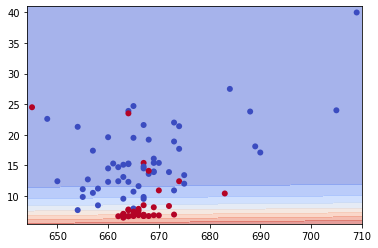

In [39]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

plot_decision_boundary(X_train, y_train, model, cmap='coolwarm')

In [40]:
df_2 = pd.read_csv(r"/Users/utkarshtripathi/Documents/PlatformIO/Projects/Data_Collected/complete_2.csv")
properties_2 = list(df_2.columns.values)
properties_2.remove('Class')

X = df_2[properties_2]
y = df_2['Class']
properties_2 = list(df_2.columns.values)
properties_2.remove('Class')
X = df_2[properties]
y = df_2['Class']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=0)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_2, y_train_2, epochs=150, batch_size=1, verbose = 0)
test_loss, test_acc = model.evaluate(X_test_2, y_test_2)
print('Test accuracy:', test_acc)

model.save('/Users/utkarshtripathi/Documents/PlatformIO/Projects/Models/second.h5')

40/40 [==============================] - 0s 2ms/sample - loss: 0.1783 - accuracy: 0.9750
Test accuracy: 0.975


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x141ac9290>)

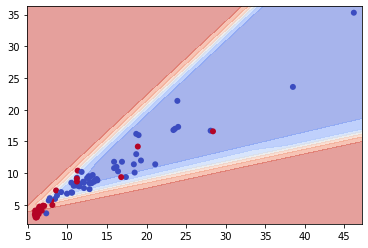

In [41]:
X_train_2 = X_train_2.to_numpy()
y_train_2 = y_train_2.to_numpy()

plot_decision_boundary(X_train_2, y_train_2, model, cmap='coolwarm')

In [44]:
df_3 = pd.read_csv(r"/Users/utkarshtripathi/Documents/PlatformIO/Projects/Data_Collected/complete_3.csv")
properties_3 = list(df_3.columns.values)
properties_3.remove('Class')

X = df_3[properties_3]
y = df_3['Class']
properties_3 = list(df_3.columns.values)
properties_3.remove('Class')
X = df_3[properties_3]
y = df_3['Class']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.3, random_state=0)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_3, y_train_3, epochs=150, batch_size=1, verbose=0)
test_loss, test_acc = model.evaluate(X_test_3, y_test_3)
print('Test accuracy:', test_acc)

model.save('/Users/utkarshtripathi/Documents/PlatformIO/Projects/Models/third.h5')



40/40 [==============================] - 0s 3ms/sample - loss: 0.1193 - accuracy: 0.9750
Test accuracy: 0.975


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x142e5b090>)

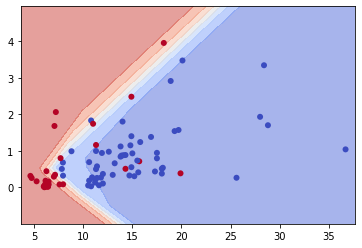

In [45]:
X_train_3 = X_train_3.to_numpy()
y_train_3 = y_train_3.to_numpy()

plot_decision_boundary(X_train_3, y_train_3, model, cmap='coolwarm')

In [ ]:
## CHECK AN INPUT
# a= np.array([[667,5]])
# print(model.predict(a))
# model.summary()

In [ ]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from sklearn.model_selection import train_test_split

# # df = np.vstack((features_mean_stddev, class_binary))
# # df = df.T
# ### Col1-Means, Col2-Devs, class (0/1)
# ## -, -, c
# ## -, -, c
# ## -, -, c
# ## .....
# ## -, -, c


# var_data = pd.read_csv(r"/Users/utkarshtripathi/Documents/PlatformIO/Projects/Data_Collected/complete.csv")


# # mean_all_tmp_propCol = list(mean_all_tmp)
# mean_all_tmp_propCol = (mean_all_tmp)
# # mean_all_tmp_propCol.insert(0, 'Mean')
# print(np.shape(mean_all_tmp_propCol))

# stdev_tmp_propCol = (stdev_tmp)
# # stdev_tmp_propCol = list(stdev_tmp)
# # stdev_tmp_propCol.insert(0, 'Std_dev')
# print(np.shape(stdev_tmp_propCol))

# # class_binary_propCol = list(class_binary)
# class_binary_propCol = (class_binary)
# # class_binary_propCol.insert(0, 'Class')
# print(np.shape(class_binary_propCol))

# # print(mean_all_tmp_propCol)
# # print(stdev_tmp_propCol)
# # print(class_binary_propCol)

# ## Now stack and make a list of properties and classes -> 'full'
# full_1 = np.vstack((mean_all_tmp_propCol ,stdev_tmp_propCol))
# full_2 = np.vstack((full_1 ,class_binary_propCol))

# properties = list(full_1.T)
# print(np.shape(properties))
# print(type(properties)) # LIST

# train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.3, random_state=0)

# X = properties
# y = class_binary_propCol
# train_data = np.asarray(train_data)
# test_data = np.asarray(test_data)


# print('X (Properties) shape',np.shape(X))
# print('y (classe_binary_propCol) shape',np.shape(y))
# print('train_data shape',np.shape(train_data))
# print('train_label shape',np.shape(train_label))
# print('test_data shape',np.shape(test_data))
# print('test_label shape',np.shape(test_label))

# train_label = np.asarray(train_label)
# test_label  = np.asarray(test_label)

# print(type(train_label))
# print(type(train_label))

# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(2,)),
#     keras.layers.Dense(16, activation=tf.nn.relu),
#     keras.layers.Dense(16, activation=tf.nn.relu),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid),
# ])

# model.compile( optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'] )

# model.fit( train_data, train_label, epochs=50, batch_size=1 )
# test_loss, test_acc = model.evaluate( test_data, test_label )

# print(type(X_train))
# print(type(X))

# print(np.shape(y_train))
# print(y.shape)
